# Outliers are Liars

Author: Marcello Chiuminatto

Python version: 3.10.4

## Overview

In the context of FOREX trading, in the commitment for finding profitable trading strategies, you will find in books, articles, papers, web sites and maybe from your own inspiration, strategies that shows positive profits, based on cumulative profit over a period. Well, that is not enough unfortunately, because does not necessarily indicate consistency in the profits.

Would be profit average (expected profit) then be a good indicator of profits consistency? The answer is not straight forward: not necessarily. Why? and the answer to this question is the topic of this analysis: Outliers. 

Outliers will distort the reading of cumulative profits and expected profits in such a way that a losing strategy, can look like a profitable one.

Consider the following example:
Let's define a strategy S, from which we get a sample of 50 trades whose profits are distributed as shown in the next table:


|        |Trades | Profit/trade[pips] |Total Profit[pips]|
|--------| ------|--------------------|------------------|
|        |  25   |   -5.0             |        -125.0    |    
|        |  24   |   2.0              |          48.0    |
|        |  1    |  200.0             |         200.0    |
|--------|-------|--------------------|-------------------
| Total  |  50   |                    |         123.0    |
| mean   |       |                    |         2.5      |
| median |       |                    |         -1.5     |



Total profit and average profit are positive, but clearly this is strongly influenced by the 200 pip trade. Pay close attention to median though, is telling something about this case.

Based on a real but simple trading strategy, it will be shown how outliers impacts mean and total profits, however median signals that something is hiding behind the scenes.

Throughout this article, it will be shown with a real, but simple trading strategy, the danger of not paying attention to outliers and in the process of showing so, it is presented the trading strategy research life cycle: design /  back-testing, analysis, and conclusions.

## Strategy Design

### Definition and Concepts

This strategy is one of the simplest trend-following or momentum FOREX trading strategy.

For simplicity, this analysis focuses only on buying (long) strategy.

The rationale behind the strategy is the following: *“When price “accelerates” enough to the upside it is likely that will remain that way for a while, so is a good signal for opening a buying position and keep it open until market decelerate.”*

To have an actionable and testable strategy is necessary to define in mathematical terms the concepts involved in the above statement: acceleration and deceleration. It necessary to remark that these concepts are defined in the context of this trading strategy analysis only and under no way are general concepts that can necessarily be applied to ALL trading strategies or financial markets.

Being that said and reducing the abstraction level a bit, market acceleration is defined as: when prices close above a fast-moving average, which is above a medium-moving average, which at the same time is above a slow-moving average.

Market deceleration is defined as: when the fast-moving average cross below the medium-moving average.

**What is a Moving Average (MA) of $n$ periods?**

It is the average of the last $n$ available price periods. Generally, is calculated on close price (which is the case for this research), but can also be calculated on open, high, low, typical price etc.)


Mathematically:

$MA(close;n)=\frac{1}{n}\sum_{i=t-n+1}^{i=0} close_i$


*Simple moving average on close parametrized with n (periods)*

Where:

- $n$ Number of periods
- $close_i$: close price at i-th period


*What are fast, medium and slow moving averages?*

The concept of speed for a MA's is given by the number of periods the MA is calculated on; less number periods will make the MA to react *faster* to price action whilst greater number of periods will make it *slower*.

In this context the periods for the three different MA are defined as follows:

* Fast MA ($MA_f$): 10 periods
* Medium MA ($MA_m$): 25 periods
* Slow MA ($MA_s$): 50 periods


### Long entry/exit rules

Now it is time to concretely define the strategy Entry/Exit/Management rules.

 **Entry**<br><br>
  Enter long when close cross above $SMA_f$ and $SMA_f$ is above $SMA_m$ and $SMA_m$ is above $SMA_s$
  
  Mathematically:
  
  Enter long when the following two conditions are true
  
  1. $close_{t-1}<SMA_f \land close_t > SMA_f$
  2. $SMA_s < SMA_m < SMA_f$
 
  **Exit**<br><br> 
  Exit a long position when $SMA_f$ cross below $SMA_m$

  Mathematically

  Exit when
  1. $SMA_f<SMA_m$

<img src="./long_setup_example.png">




## Strategy Back-testing

Strategy back-testing is in essence simulating the strategy logic on historic data, expecting that past performance will repeat in the feature. But this is not necessarily the case and depends a lot on how the back-testing process is designed and executed, among other conditions. Detailed back-testing discussion is out of the scope of this analysis. As a starter you can find more here: https://www.investopedia.com/terms/b/backtesting.asp.

What is relevant for this analysis is that back-testing will produce a set of trades that if considered right out of the process they seem to be produced by a profitable strategy, but hypothetically this is not true and the real losing results are hidden by outliers.

In this section are presented some steps to implement a simple *vectorized* back-testing process. The term **vectrorized** means that instead of looping throughout the elements of an array or a matrix performing scalar operations, the operations are performed on entire arrays or matrices (vectors). Why to do so? because the reduction of processing time is significant, specially when working with millions or billions of records. You can find more here: https://www.youtube.com/watch?v=BR3Qx9AVHZE






### Imports

In [1]:
%run support_code.py

### Global Variables

In [2]:
SMA_fast = 10
SMA_med = 25
SMA_slow = 50

COL_f = f'SMA_{SMA_fast}'
COL_m = f'SMA_{SMA_med}'
COL_s = f'SMA_{SMA_slow}'

PLOT_FROM = 2000
PLOT_TO = 2200

SYMBOL='EURUSD'

DIGITS = 4  # digits where the pip change is counted
if 'JPY' in SYMBOL:
    DIGITS=2
    
PIP_FACTOR = 10**DIGITS  # factor to convert from points change to pip change

TRADE_COST = 0.5  # estimated spread + commission per trade


### Data

The data for this study is for the instrument (currency cross pair) EURUSD, format OHLC (Open/High/Low/Close) aggregated at a fix frequency of one hour (H1) in the period from 2015-01-01 22:00:00 until 2021-11-24 23:00:00

Sample:

In [3]:
df = pd.read_csv('EURUSD_Hourly_Bid_2015.01.01_2021.11.24.csv')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)']) 
df.set_index('Time (UTC)', inplace=True)
df.tail()

,Open,High,Low,Close,Volume
Time (UTC),,,,,
2021-11-24 19:00:00,1.11925,1.12034,1.11883,1.11985,3332.690
2021-11-24 20:00:00,1.11984,1.12053,1.11976,1.12050,1500.710
2021-11-24 21:00:00,1.12049,1.12054,1.11962,1.11962,1051.825
2021-11-24 22:00:00,1.11957,1.12020,1.11944,1.12001,662.320
2021-11-24 23:00:00,1.11997,1.12042,1.11997,1.12025,465.710


In [4]:
print('Records ', df.shape[0])
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5),
         title=SYMBOL, savefig="price.png")

Records  42988


### Feature Calculation

Besides price, the three moving averages need to be calculated: $SMA_f$ (fast), $SMA_m$ (medium) and $SMA_s$ (slow)

In [5]:
df[COL_f] = df['Close'].rolling(SMA_fast).mean()
df[COL_m] = df['Close'].rolling(SMA_med).mean()
df[COL_s] = df['Close'].rolling(SMA_slow).mean()
df.dropna(inplace=True)

In [6]:
ap0 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
       mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green')]

In [7]:
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap0, title=f'{SYMBOL} / {COL_f} - {COL_m} - {COL_s}', savefig="features.png")

### Strategy Vectorization

For this strategy, the required steps for vectorization are the following:

* Mark entry and exit signal
* Mark trading periods
* Reduce trading periods to trades
* Calculate profits

These steps that are followed here are not mandatory and can and probably will change from strategy to strategy, from trader to trader and for many other reasons.

Worth to mention that key tools for vectorization are python libraries: Numpy and Pandas.


#### Mark Entry and Exit Signal

A signal is a flag a light or anything indicating that some condition has been reached and someone or something must execute an action accordingly.

In the case of this strategy and depending on the required action that needs to be triggered, there are two kind of signals: entry signal, triggering a buy action to open a position, and exit signal, triggering a sell action to close a position.

In the context of this strategy also, the signals are calculated and risen once a period is closed, when period's close price is available and therefore it is possible to calculate all moving averages based on it. This is not the only approach though, some strategies could trigger signals based on tick data arriving each second for example, when a period is not yet closed.

Remember that this is a buy only (long) strategy, so the signal space is limited. Broader strategies could have wider signal spaces, containing for example entry, adjust, increase size, decrease size, close signals, to name a few.


<b>Entry Signal: Cross over condition</b>

The entry signal is raised when the last available close price crosses above the fast SMA, along with fast SMA being above med SMA and med SMA being above the slow SMA.

$signal_i = (open_{i} < SMA_{fast, i} < close_{i})  \land (SMA_{slow, i} < SMA_{med, i} < SMA_{fast, i})$

Where:

* $Close_{i}$: Last closed bar close price.
* $Open_{i}$: Last closed bar open price.
* $SMA_{fast, i}, SMA_{med, i}, SMA_{slow, i}$: SMA fast, med and slow respectively, calculated at the last bar close.


<b>Entry period</b>

The entry period is marked right at the opening of current bar, if signal was risen for the last closed bar.


$entry_i=\begin{cases}
    1 \text{ if }signal_{i-1} = True\\
    \emptyset \text{ otherwise}
\end{cases}
$

Where:

* $entry_i$: Indicates if a trade needs to be opened at current period.
* $signal_{i-1}:$ Signal at last closed bar.


<b>Exit Signal</b>

The exit signal is raised when the close price crosses below the med SMA, therefore, following the entry.

<b>Exit Signal</b>

$x\_signal_i = close_{i} < SMA_{med, i} < close_{i-1}$

<b>Exit Signal</b>

$exit_i = \begin{cases}
    -1 \text{ if }x\_signal_{i-1} = True \\
    \emptyset \text{ otherwise}
\end{cases}
$

In the example below:


| t | Entry/Exit Signal | Entry/Exit Period | Trade |
| - | ----------------- | ----------------- | ----- |
| 1 |                   |                   |       |
| 2 | 1                 |                   |       |
| 3 |                   | 1                 | 1     |
| 4 |                   |                   | 1     |
| 5 |                   |                   | 1     |
| 6 | \-1               |                   | 1     |
| 7 |                   | \-1               |       |
| 8 |                   |                   |       |


- $t=2$: entry signal risen at the close of 2nd bar.
- $t=3$: entry condition is met, so a long trade is open right at the opening of the 3rd bar.
- $t=6$: exit signal is risen at the close of 6th bar.
- $t=7$: exit condition is met, so the trade is closed right at the opening of the 7th bar.



#### Mark Entry and Exit Signal

In [8]:
df['trade'] = np.nan
df['signal'] = np.nan
df['entry'] = np.nan
df['exit'] = np.nan


from SignalLib.Signal import Signal


# define entry signal condition
mask_signal =    (df['Close'] > df[COL_f]) & (df['Open'] < df[COL_f]) & \
                 (df[COL_f] > df[COL_m]) &  (df[COL_m] > df[COL_s]) # SMA positioning

#define exit signal condition
mask_x_signal = (df['Close'] < df[COL_m]) & (df['Open'] >  df[COL_m])


print("df shape ", df.shape, "entry shape ", mask_signal.shape, "exit shape ", mask_x_signal.shape)
sig_calc = Signal()

singnal_col = sig_calc.compute(df, mask_signal, mask_x_signal)

# plotting adjustments
df.loc[(df['signal']==1), 'plot_signal'] = df[COL_s] - 0.0010
df.loc[(df['signal']==-1), 'x_plot_signal'] = df['High'] + 0.0010


df shape  (42939, 12) entry shape  (42939,) exit shape  (42939,)


In [9]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_signal'],type='scatter', marker=6, color="r"),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['x_plot_signal'],type='scatter', marker=7, color="b"),
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Signal', savefig="entry_exit.png")

#### Mark Entry/Exit condition

#### Mark Trades

In [10]:
from Trades.Trades import MarkDiscontinuous

_trades = MarkDiscontinuous(4)
df = _trades.mark_trades(df, singnal_col)

In [11]:
# prepare plotting columns
mask_trade = df['trade'].isna()
df.loc[~mask_trade, 'plot_trade'] = df.loc[~mask_trade][COL_s] - 0.0005

In [12]:
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]][2190:2200]
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]].to_csv("bench_trades.csv")
df[[_trades.trade_col_name, _trades.trade_id_col_name, _trades.entry_exit_period_col_name]].to_csv("trades_periods.csv")

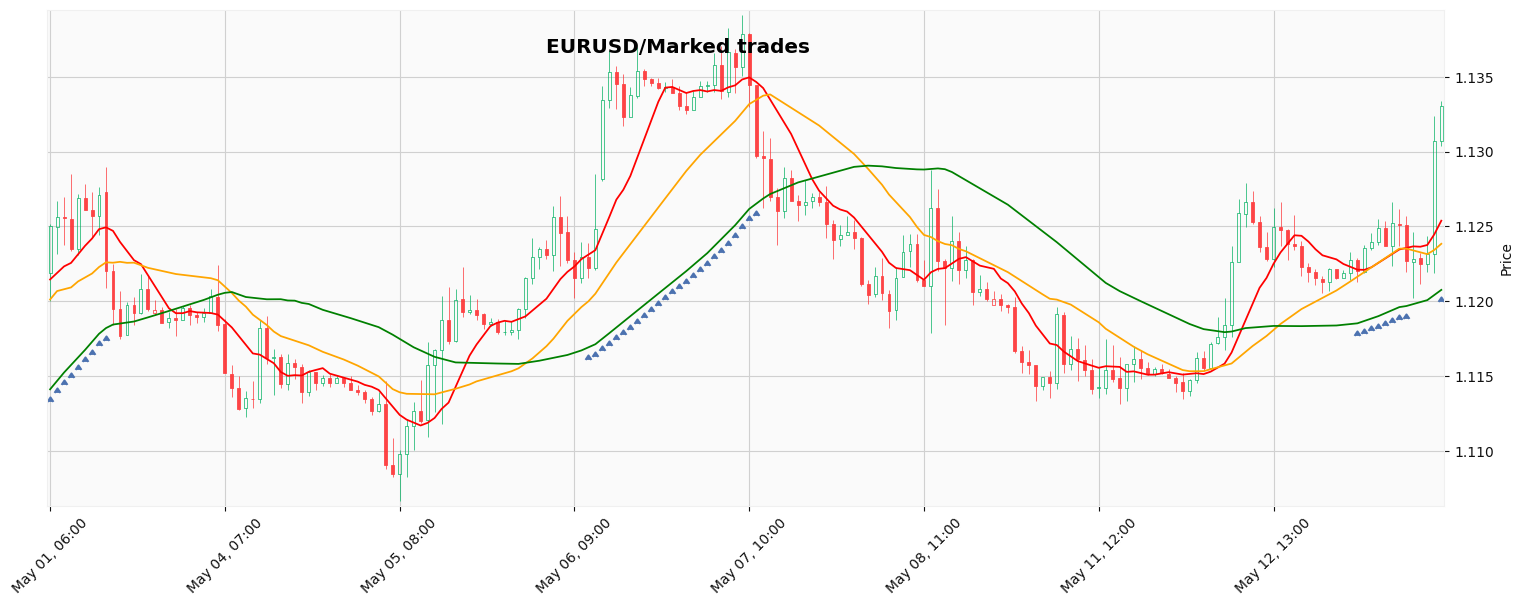

In [13]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_trade'],type='scatter', marker=6, color="b")
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Marked trades')

#### Trades Reduction

This process is also part of the strategy vectorization and consists of transforming from period-wise trade markings to trade-wise records. The attributes that define a trade could be open date/time, close date/time, open price, close price, number of trading periods, to name a few. What attributes to include is a decision that depends on the problem's context. In this case open date/time, close date/time and gross profit are enough.

<img src="reduction.png" width="600">

In [14]:
# TRADE REDUCTION

df_trades = _trades.compute(df, singnal_col)
df_trades.to_csv("trades_reduced.csv")

#### Profit Calculation

With trades in place, now it is possible to perform profits calculations along with some profits related metrics.

In the context of this study, one profit related calculation is required: net profit, which is the result of subtracting trade cost from gross profit:

$NP = GP - Cost$

Where

$NP$: Net Profit<br>
$GP$: Gross Profit<br>
$Cost$: Trading Cost<br>

**Trading Cost**

Usually overlooked, Trading Cost is a critical variable that can make the difference between a profitable strategy and a losing one. Maybe you have read books, papers or publications that shows very profitable strategies not mentioning trading cost though. Most probably is they didn't consider it, because if they did, the strategy wouldn’t be as profitable as they presented it.

More detail on trading cost calculation is out of the scope of this study and deserve an analysis by itself, enough is to say that its calculation is a function of spread and commission. The value used in this analysis is 0.5 pips per trade

The following image presents the gross and net profit for the strategy under analysis.

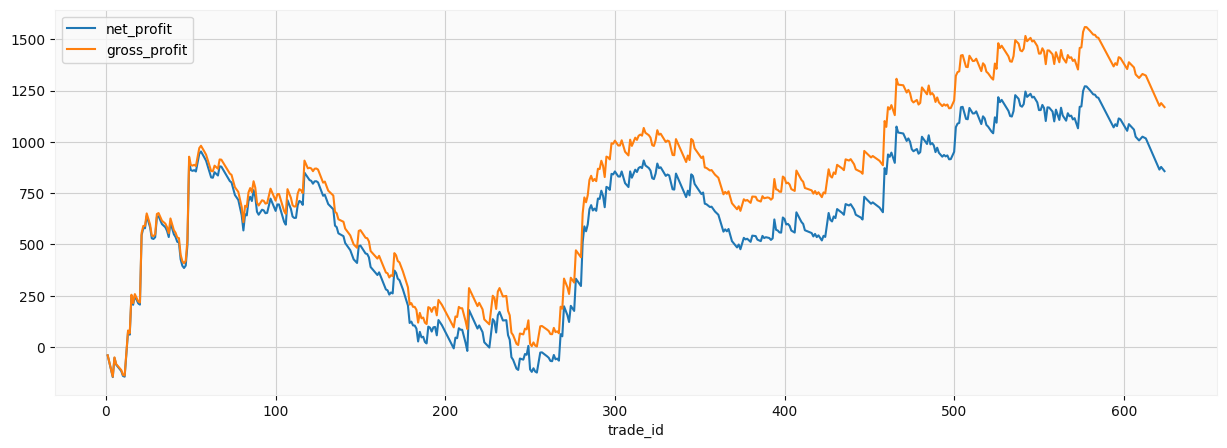

In [15]:
from ProfitsLib.Profits import Profits

_profits = Profits(net_pft_col="net_profit",cum_pft_col="cum_profit", gross_profit_col="gross_profit")
_profits.compute(df_trades, TRADE_COST)

df_trades['net_profit'] = df_trades['gross_profit'] - TRADE_COST
df_trades[['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))

plt.savefig("gp_np.png")
plt.show()

In [16]:
df_trades["net_profit"].skew()

3.3620066972571583

In [17]:
df_trades.head(5)

,gross_profit,date_open,date_close,net_profit,cum_profit
trade_id,,,,,
1.0,-40.1,2015-01-12 04:00:00,2015-01-12 08:00:00,-40.6,-40.6
2.0,-38.7,2015-01-22 09:00:00,2015-01-22 13:00:00,-39.2,-79.8
3.0,-47.1,2015-01-30 11:00:00,2015-01-30 12:00:00,-47.6,-127.4
4.0,-18.3,2015-02-03 01:00:00,2015-02-03 03:00:00,-18.8,-146.2
5.0,94.0,2015-02-03 11:00:00,2015-02-04 09:00:00,93.5,-52.7


In [18]:

for k  in _profits.metrics:
    print(k, '\t  :', round(_profits.metrics[k],2))

total_trades 	  : 624
winning_trades 	  : 184
losing_trades 	  : 440
avg_winning 	  : 46.12
avg_losing 	  : -17.34
total_pl 	  : 857.3
total_profit 	  : 8486.3
total_loss 	  : -7629.0
stdev_pl 	  : 43.93
stdev_cum_pl 	  : 372.23
avg_profit 	  : 1.37
median_profit 	  : -8.25
skew_pl 	  : 3.36


Mean 1.3738782051279987
Median -8.249999999999702


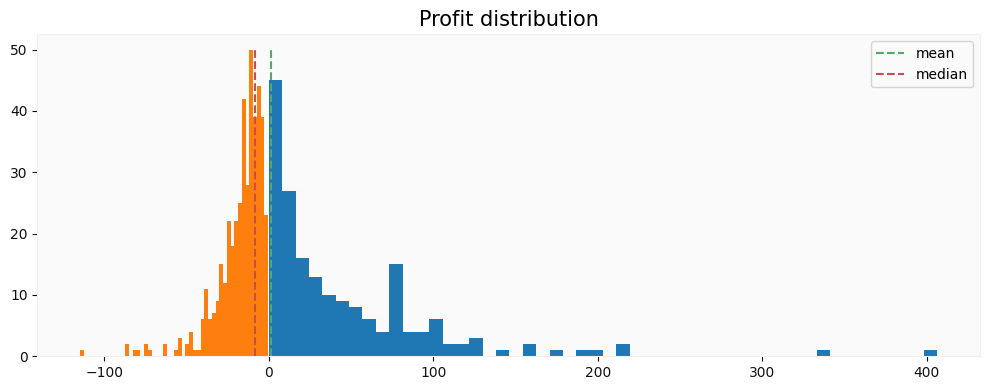

In [19]:
mean_x = _profits.metrics['avg_profit']
median_x = _profits.metrics['median_profit']


print("Mean", mean_x)
print("Median", median_x)

fig, ax = plt.subplots(1,1, figsize=(10,4))

ax.plot([mean_x, mean_x], [0, 50], color='g', linestyle='--', label='mean')
ax.plot([median_x, median_x], [0, 50], color='r', linestyle='--', label='median')
ax.legend()
ax.set_title('Profit distribution', size=15)


df_trades[(df_trades["net_profit"]>0)]['net_profit'].hist(grid=False, bins=50, ax=ax)
ax.legend()
ax.set_title('Winning trades profit distribution', size=15)

df_trades[(df_trades["net_profit"]<=0)]['net_profit'].hist(grid=False, bins=50, ax=ax)
ax.legend()
ax.set_title('Profit distribution', size=15)

plt.savefig("raw_profit_dist.png")
fig.tight_layout()
plt.show()

**Observations**

Even though the strategy is profitable for the time range back-tested, it is not consistent.

Mainly relies on outliers, which pull the mean (expected profit) to the positive side, but the median (less sensitive to outliers) is negative, showing that the bulk of the trades are in the negative side. A good strategy would have both statistics in the positive side.

All this is confirmed by skewness which is positive indicating a right tailed distribution, which is not good considering median below zero.

What if outliers are removed? The hypothesis is that this strategy relies only on outliers and removing them would turn this strategy into a losing one in average, meaning that the average profit should shift to the negative side.


### Results Analysis

Considering that proportion of winning trades (observation 2) is low and that e the strategy is profitable (observation 1) it is possible to hypothesize that the winning trades average should be high and losing ones low, which is confirmed by observation 4.

There are two possible explanations for high winning trades average: a) Concentration around the average, which is signal that the strategy is consistent and b) The presence of outliers, which signals the opposite than a). Clearly a) is not the case because winning trades average profit is not concentrated around 46.12 and it is evident the presence of positive outliers (observation 3).

It is almost evident that the strategy is heavily dependent on outliers, so next step is comparing the strategy performance with and without outliers through an statistical tool: Confidence Intervals

## Outliers Removal

### Previous Considerations

Before removing outliers two aspects, related to data and the confidence intervals tool, need to be taken into consideration.

a)	**Profit Distribution**. Profit distribution is not normal, and confidence intervals relies on normality which invalidates raw profit for the analysis. To overcome this issue, it is at hand the Central Limit Theorem. It is necessary then to define a statistic and do sampling to calculate it. For this analysis the statistic of choice is profit mean, so the sampling process will produce mean sampling, which is assumed as normal distributed. This means that instead of analyzing raw profit, the analysis now shifts to profit mean.

b)	**Sampling on time series**. With cross sectional data (not time related) it is possible to perform sampling techniques like bootstrapping for example, but profits variable is a time series, and there could be correlations (auto-correlation) between consecutive values.  For example, opening time for trade $t+1$ was affected because trade $t$ was open at the time it should have been opened. Even tough autocorrelation detection is out of the scope of this analysis and for simplicity auto-correlation will be assumed. You can go deeper in some auto-correlation detection techniques like Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF).

For time series bootstrapping there are some techniques, like block bootstrapping, with and without overlapping, among others. To maximize the number of samples, simple block bootstrapping with overlapping is used in this analysis. The following image describe in essence what this technique consists of.

 <img src = "BootStrapTS.png" width="700">

**Confidence Interval Parameters**

 To calculate confidence interval the assumptions are:

* Confidence level: 95 (alpha = 0.05)<br>
* Sample size: 60


### Profit Mean Confidence With Outliers

In [20]:

from BootstrapLib.Bootstrap import BlockBSWithOverlap

alpha = 0.05
bsp = BlockBSWithOverlap()
bsp.compute(df_trades["net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)


 sampling mean: 1.17, 
                    sampling median: 0.25
                    sampling std: 6.42, 
                    sampling standard error: 0.27,
                    sampling min: -13.02,
                    sampling max: 16.64
confidence interval: [0.64, 1.7], mean: 1.17, standard error: 0.27


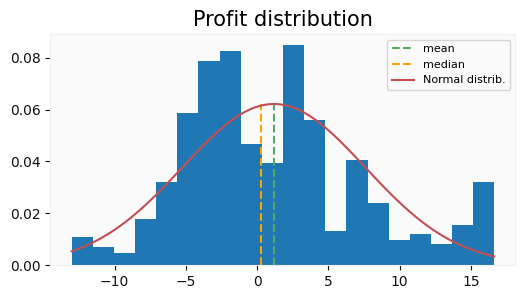

In [21]:
plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)

**Observations**

 * 95% of the times the average profit will be in the range of $[0.64, 1.70]$  pips, which is good because in average the strategy is profitable.


This confidence interval is a benchmark to compare with no outliers performance.


## Outliers Control

There are many approaches to remove outliers: trimmed mean, values outside confidence intervals and more. For this analysis, two approaches are being taken into consideration: The trading approach and a mathematical approach.

The trading approach considered to remove outliers, is to use trading's risk management tools: Stop Loss and Take Profit. In general terms, Stop Loss controls the loss risk (under a normal market context of volatility not like this context:https://www.dailyfx.com/forex/market_alert/2015/01/15/Swiss-Franc-Skyrockets-as-SNB-Announce-End-of-Currency-Floor.html) and Take Profit, limit the profits (a reason for limiting profits would be high probability of market reversal). The advantages of this approach is that no data need to be removed from the sample and makes sense from the trading perspective because stop loss and take profit are simple to apply (implemented in most trading platforms) and will work as expected most of the time.

In the other hand, using mathematical approach to remove outliers like trimming the data (removing data above 90 and below 10 percentiles) for example, in reality are difficult to implement because requires forecasting tools that can predict ahead in time when an outlier will occur, which is complex.

Being that said, the most feasible approach is the trading one, but both will be applied for research purposes.

### Trading Approach

This approach considers applying risk management tools to reduce outliers:  Stop Loss (SL) and Take Profit (TP)

SL levels and TP levels are set using standard deviation of net profits. SL will be set at one standard deviation and TP will be set at two standard deviations (thre are as many criteria to define take profit and stop loss levels as traders exists)


This way, the profit range is:

$PR = [-s, 2s]$

Where:

$s$: profit standard deviation


In [22]:

# limit losing trades by stop loss
std_gross_profit = df_trades["gross_profit"].std()

print("Before Removing Outliers : Min profit ", min(df_trades["gross_profit"].values), "max profit ", max(df_trades["gross_profit"].values))
df_trades["limit_gross_profit"] = df_trades["gross_profit"].clip(-std_gross_profit, 2*std_gross_profit)
df_trades["limit_net_profit"] =  df_trades["limit_gross_profit"] - TRADE_COST
print("After Removing Outliers : Min profit ", min(df_trades["limit_gross_profit"].values), "max profit ", max(df_trades["limit_gross_profit"].values))

Before Removing Outliers : Min profit  -114.09999999999921 max profit  406.79999999999825
After Removing Outliers : Min profit  -43.92717752033775 max profit  87.8543550406755


<AxesSubplot:xlabel='trade_id'>

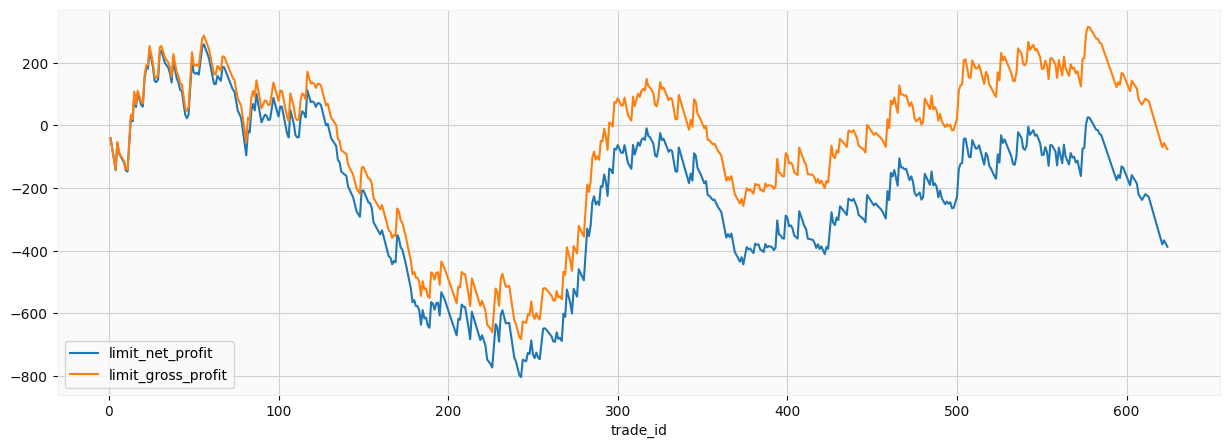

In [23]:
df_trades[['limit_net_profit', 'limit_gross_profit']].cumsum().plot(figsize=(15,5))

In [24]:
alpha = 0.05
bsp = BlockBootStrapSamp()
bsp.compute(df_trades["limit_net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)

plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)


NameError: name 'BlockBootStrapSamp' is not defined

**Observations**

Limiting loss and profits to remove outliers so the trading strategy will not rely on them, it is possible to appreciate that the profit mean now lays within a negative range for a confidence level of 95%.

This supports the hypothesis that this trading strategy is not a good one because relies only on outliers.


### Mathematical Approach

The mathematical approach trims the outliers by removing the profits above 90 percentile and below 10 percentile.

In [ ]:
mask_10_off = (df_trades['gross_profit'] >= df_trades['gross_profit'].quantile(.1)) & (df_trades['gross_profit'] <= df_trades['gross_profit'].quantile(.95))
df_trades.loc[mask_10_off, "trimmed_gross_profit"] = df_trades[mask_10_off]['gross_profit']
df_trades["trimmed_net_profit"] = df_trades[mask_10_off]['trimmed_gross_profit'] - TRADE_COST

<AxesSubplot:xlabel='trade_id'>

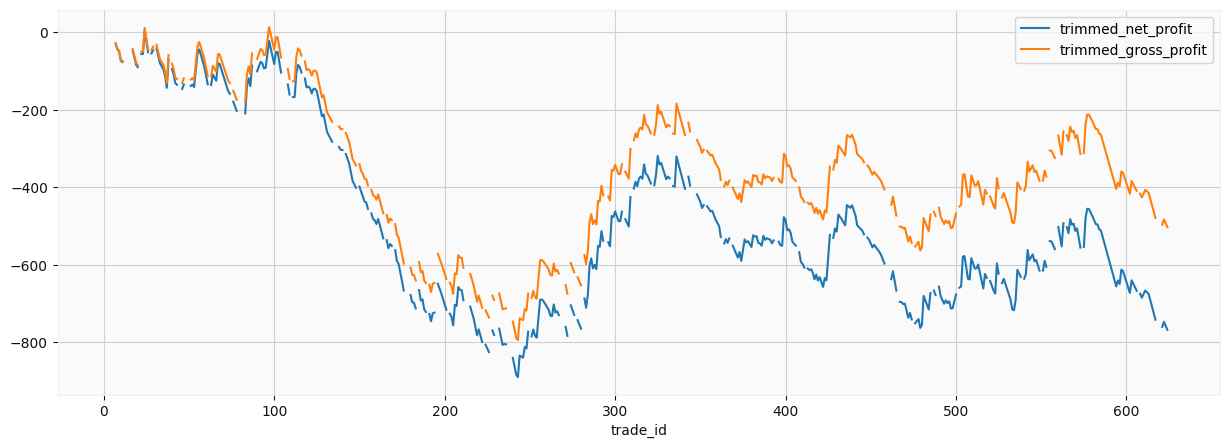

In [ ]:
df_trades[['trimmed_net_profit', 'trimmed_gross_profit']].cumsum().plot(figsize=(15,5))

 sampling mean: -1.06, 
                    sampling median: -1.04
                    sampling std: 3.88, 
                    sampling standard error: 0.18,
                    sampling min: -10.11,
                    sampling_max: 8.29
confidence interval: [-1.41, -0.71], mean: -1.06, standard error: 0.18


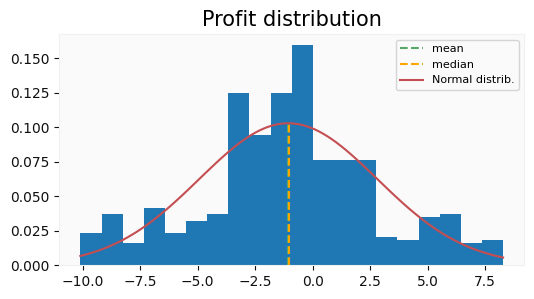

In [ ]:
alpha = 0.05
bsp = BlockBootStrapSamp()
bsp.compute(df_trades[mask_10_off]["trimmed_net_profit"], 60)
print(bsp)
ci = ConfidenceInterval()
ci.compute(alpha, bsp.sampling_mean, bsp.sampling_std_error)
print(ci)

plt_d = PlotDistribution()
plt_d.plot(bsp.mean_sampling, bsp.sampling_min, bsp.sampling_max, bsp.sampling_mean, bsp.sampling_median, bsp.sampling_std)

# confidence_interval_analysis(df_trades["trimmed_net_profit"].dropna(), 60)

**Observations**

The main observations is that as along with limiting profit and losses, this method for removing outliers, moves the mean profit towards a negative confidence interval with a 95% confidence level.

As a secondary observation, removing outliers instead of limiting values, gets the values of mean an median closer.



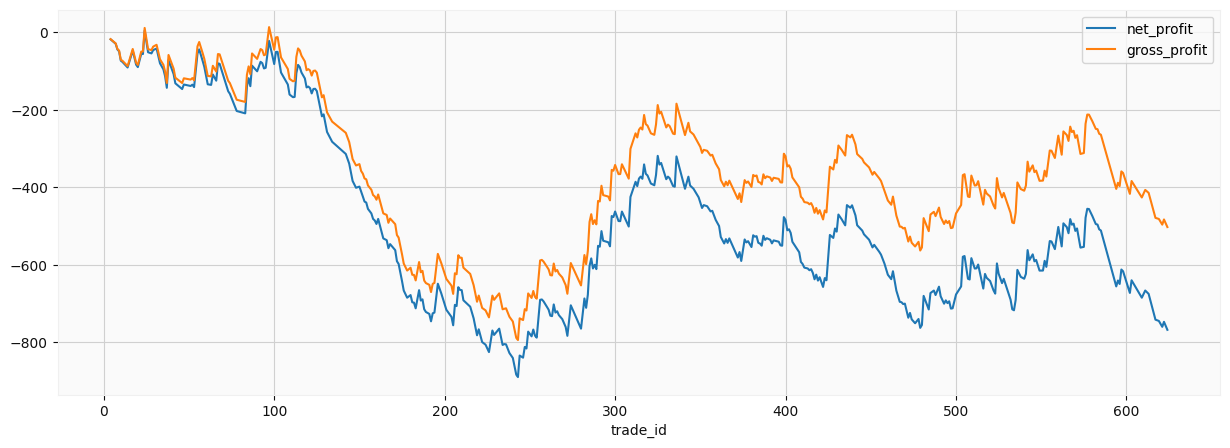

In [ ]:

df_trades[mask_10_off][['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

## Conclusion

The hypothesis that this trading strategy is not a good one because relies on outliers was confirmed. 

The original strategy was profitable (net profit greater than zero), and its sampled mean profit was positive and laying within a positive confidence interval at a confidence level 0f 95%. Observing the profit distribution though, was possible to detect the presence of outliers.

The next step was to remove or control outliers and observe is the strategy remained consistent.

After controlling outliers using two approaches: Trading and Mathematic ones, was possible to observe that in both cases the sampled profit mean moved to the negative side laying in negative confidence intervals at 95% confidence level, confirming the hypothesis.
The takeaway of this study is that on early stages of back testing consider the following facts and actions before declaring a strategy as a promising one:


1. Positive profits and positive average profits does not necessarily mean a good trading strategy so
2. Observe profit distribution and pay attention to outliers.
3. Observe mean and median, if median is negative and mean is positive most probably outliers are present.




